In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path

HR_ROOT = Path('/content/drive/MyDrive/preprocessed_SHARPS_JPGS/preprocessed_hourly_all')

print('HR_ROOT exists:', HR_ROOT.exists())
hr_imgs = sorted(HR_ROOT.glob('**/*.jpg'))
print('Total HR images found:', len(hr_imgs))
print('Example paths:')
for p in hr_imgs[:5]:
    print('  ', p)

HR_ROOT exists: True
Total HR images found: 78873
Example paths:
   /content/drive/MyDrive/preprocessed_SHARPS_JPGS/preprocessed_hourly_all/1012/hmi.sharp_cea_720s.1012.20111027_010000_TAI.magnetogram.jpg
   /content/drive/MyDrive/preprocessed_SHARPS_JPGS/preprocessed_hourly_all/1012/hmi.sharp_cea_720s.1012.20111027_020000_TAI.magnetogram.jpg
   /content/drive/MyDrive/preprocessed_SHARPS_JPGS/preprocessed_hourly_all/1012/hmi.sharp_cea_720s.1012.20111027_030000_TAI.magnetogram.jpg
   /content/drive/MyDrive/preprocessed_SHARPS_JPGS/preprocessed_hourly_all/1012/hmi.sharp_cea_720s.1012.20111027_040000_TAI.magnetogram.jpg
   /content/drive/MyDrive/preprocessed_SHARPS_JPGS/preprocessed_hourly_all/1012/hmi.sharp_cea_720s.1012.20111027_050000_TAI.magnetogram.jpg


In [ ]:
import random

all_hr_paths = hr_imgs
print('Total HR images available:', len(all_hr_paths))

subset_size = 3500

if len(all_hr_paths) < subset_size:
    raise ValueError(
        f'Requested {subset_size} images but only {len(all_hr_paths)} found in HR_ROOT.'
    )

random.seed(42)
random.shuffle(all_hr_paths)

subset_paths_hr = all_hr_paths[:subset_size]
print('Subset size:', len(subset_paths_hr))

train_size = 2800
val_size   = 350
test_size  = 350

train_paths_hr = subset_paths_hr[:train_size]
val_paths_hr   = subset_paths_hr[train_size:train_size + val_size]
test_paths_hr  = subset_paths_hr[train_size + val_size:train_size + val_size + test_size]

print('Train paths:', len(train_paths_hr))
print('Val paths:', len(val_paths_hr))
print('Test paths:', len(test_paths_hr))

Total HR images available: 78873
Subset size: 3500
Train paths: 2800
Val paths: 350
Test paths: 350


In [ ]:
!git clone https://github.com/JingyunLiang/SwinIR.git
%cd SwinIR
!pip install einops scikit-image

Cloning into 'SwinIR'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 333 (delta 6), reused 2 (delta 2), pack-reused 323 (from 2)
Receiving objects: 100% (333/333), 29.84 MiB | 22.96 MiB/s, done.
Resolving deltas: 100% (119/119), done.
/content/SwinIR


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import random

class SolarSharpSRDataset(Dataset):
    """Patch-based SR dataset.

    For each HR image path, we:
      - load HR (≈512×512) as grayscale
      - downsample by factor 2 (bicubic) to create LR (≈256×256)
      - sample a random 64×64 LR patch and corresponding 128×128 HR patch
    """

    def __init__(
        self,
        paths_hr,
        lr_patch_size=64,
        upscale=2,
        n_patches_per_image=1,
    ):
        self.paths_hr = list(paths_hr)
        self.lr_patch_size = lr_patch_size
        self.hr_patch_size = lr_patch_size * upscale
        self.upscale = upscale
        self.n_patches_per_image = n_patches_per_image

    def __len__(self):
        return len(self.paths_hr) * self.n_patches_per_image

    def __getitem__(self, idx):
        img_idx = idx // self.n_patches_per_image
        hr_path = self.paths_hr[img_idx]

        hr_img = Image.open(hr_path).convert('L')
        W_hr, H_hr = hr_img.size  # PIL: (width, height)

        lr_size = (W_hr // self.upscale, H_hr // self.upscale)
        lr_img = hr_img.resize(lr_size, Image.BICUBIC)

        lr = np.array(lr_img, dtype=np.float32) / 255.0
        hr = np.array(hr_img, dtype=np.float32) / 255.0

        H_lr, W_lr = lr.shape
        ps = self.lr_patch_size  # 64

        x_lr = random.randint(0, W_lr - ps)
        y_lr = random.randint(0, H_lr - ps)
        lr_patch = lr[y_lr:y_lr+ps, x_lr:x_lr+ps]

        x_hr = x_lr * self.upscale
        y_hr = y_lr * self.upscale
        ps_hr = self.hr_patch_size
        hr_patch = hr[y_hr:y_hr+ps_hr, x_hr:x_hr+ps_hr]

        lr_patch = torch.from_numpy(lr_patch).unsqueeze(0)  # (1,64,64)
        hr_patch = torch.from_numpy(hr_patch).unsqueeze(0)  # (1,128,128)
        return lr_patch, hr_patch

# Create datasets
train_dataset = SolarSharpSRDataset(
    train_paths_hr,
    lr_patch_size=64,
    upscale=2,
    n_patches_per_image=2,
)
val_dataset = SolarSharpSRDataset(
    val_paths_hr,
    lr_patch_size=64,
    upscale=2,
    n_patches_per_image=2,
)
test_dataset = SolarSharpSRDataset(
    test_paths_hr,
    lr_patch_size=64,
    upscale=2,
    n_patches_per_image=4,
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True,
                          num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False,
                          num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False,
                          num_workers=0, pin_memory=True)

len(train_dataset), len(val_dataset), len(test_dataset)

(5600, 700, 1400)

In [ ]:
from models.network_swinir import SwinIR
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

#SwinIR
model = SwinIR(
    upscale=2,
    in_chans=1,
    img_size=64,
    window_size=8,
    img_range=1.0,
    depths=[6, 6, 6, 6],
    embed_dim=60,
    num_heads=[6, 6, 6, 6],
    mlp_ratio=2,
    upsampler='pixelshuffle',
    resi_connection='1conv'
).to(device)

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Device: cuda


In [ ]:
ckpt_path = "/content/drive/MyDrive/sharp_sr_checkpoints_3p5k/swinir_solar_x2_medium_3p5k_epoch20.pth"

state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state)
model.eval()

print("Loaded checkpoint:", ckpt_path)


Loaded checkpoint: /content/drive/MyDrive/sharp_sr_checkpoints_3p5k/swinir_solar_x2_medium_3p5k_epoch20.pth


In [ ]:
import torch.nn.functional as F
from math import log10
from pathlib import Path

ckpt_dir = Path('/content/drive/MyDrive/sharp_sr_checkpoints_3p5k')
ckpt_dir.mkdir(parents=True, exist_ok=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
num_epochs = 20

def psnr(pred, target):
    mse = F.mse_loss(pred, target)
    return 10 * torch.log10(1.0 / mse)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for lr_patch, hr_patch in train_loader:
        lr_patch, hr_patch = lr_patch.to(device), hr_patch.to(device)

        sr_patch = model(lr_patch)
        loss = F.l1_loss(sr_patch, hr_patch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * lr_patch.size(0)

    train_loss /= len(train_dataset)

    # Validation PSNR
    model.eval()
    val_psnr = 0.0
    n = 0
    with torch.no_grad():
        for lr_patch, hr_patch in val_loader:
            lr_patch, hr_patch = lr_patch.to(device), hr_patch.to(device)
            sr_patch = model(lr_patch)
            val_psnr += psnr(sr_patch, hr_patch).item() * lr_patch.size(0)
            n += lr_patch.size(0)
    val_psnr /= n

    print(f'Epoch {epoch+1}/{num_epochs} | train L1: {train_loss:.4f} | val PSNR: {val_psnr:.2f} dB')

    torch.save(
        model.state_dict(),
        ckpt_dir / f'swinir_solar_x2_medium_3p5k_epoch{epoch+1}.pth'
    )

Epoch 1/20 | train L1: 0.0217 | val PSNR: 39.04 dB
Epoch 2/20 | train L1: 0.0107 | val PSNR: 40.64 dB
Epoch 3/20 | train L1: 0.0080 | val PSNR: 39.03 dB
Epoch 4/20 | train L1: 0.0077 | val PSNR: 38.11 dB
Epoch 5/20 | train L1: 0.0068 | val PSNR: 43.45 dB
Epoch 6/20 | train L1: 0.0058 | val PSNR: 43.73 dB
Epoch 7/20 | train L1: 0.0059 | val PSNR: 46.84 dB
Epoch 8/20 | train L1: 0.0057 | val PSNR: 43.43 dB
Epoch 9/20 | train L1: 0.0054 | val PSNR: 50.50 dB
Epoch 10/20 | train L1: 0.0050 | val PSNR: 43.03 dB
Epoch 11/20 | train L1: 0.0050 | val PSNR: 51.69 dB
Epoch 12/20 | train L1: 0.0049 | val PSNR: 47.21 dB
Epoch 13/20 | train L1: 0.0048 | val PSNR: 39.86 dB
Epoch 14/20 | train L1: 0.0048 | val PSNR: 50.60 dB
Epoch 15/20 | train L1: 0.0045 | val PSNR: 40.85 dB
Epoch 16/20 | train L1: 0.0046 | val PSNR: 42.92 dB
Epoch 17/20 | train L1: 0.0043 | val PSNR: 45.38 dB
Epoch 18/20 | train L1: 0.0041 | val PSNR: 48.49 dB
Epoch 19/20 | train L1: 0.0044 | val PSNR: 42.82 dB
Epoch 20/20 | train L

lr_batch shape: torch.Size([1, 1, 64, 64])
hr_batch shape: torch.Size([1, 1, 128, 128])


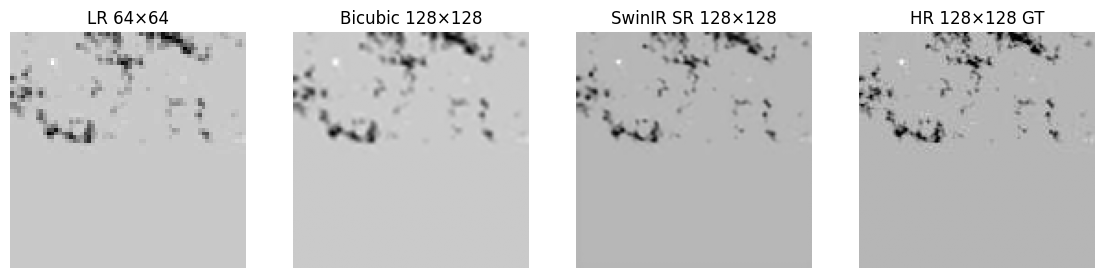

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

model.eval()

def get_non_empty_val_batch(thresh=0.02, max_tries=50):
    tries = 0
    while tries < max_tries:
        for lr_batch, hr_batch in val_loader:
            hr_np = hr_batch[0, 0].numpy()
            bg = np.median(hr_np)
            mask = np.abs(hr_np - bg) > thresh
            if mask.sum() > 20:   # non-background pixels
                return lr_batch, hr_batch
        tries += 1
    return lr_batch, hr_batch

lr_batch, hr_batch = get_non_empty_val_batch()
print("lr_batch shape:", lr_batch.shape)
print("hr_batch shape:", hr_batch.shape)

lr_batch = lr_batch.to(device)

with torch.no_grad():
    sr_batch = model(lr_batch)

lr_img = lr_batch[0, 0].detach().cpu().numpy()
sr_img = sr_batch[0, 0].detach().cpu().numpy()
hr_img = hr_batch[0, 0].detach().cpu().numpy()

# Bicubic baseline (LR upsampled to 128×128)
lr_up = F.interpolate(
    lr_batch, scale_factor=2, mode="bicubic", align_corners=False
)[0, 0].detach().cpu().numpy()

plt.figure(figsize=(14, 4))
plt.subplot(1, 4, 1); plt.imshow(lr_img, cmap="gray"); plt.title("LR 64×64"); plt.axis("off")
plt.subplot(1, 4, 2); plt.imshow(lr_up, cmap="gray"); plt.title("Bicubic 128×128"); plt.axis("off")
plt.subplot(1, 4, 3); plt.imshow(sr_img, cmap="gray"); plt.title("SwinIR SR 128×128"); plt.axis("off")
plt.subplot(1, 4, 4); plt.imshow(hr_img, cmap="gray"); plt.title("HR 128×128 GT"); plt.axis("off")
plt.show()


In [ ]:
from skimage.metrics import structural_similarity as ssim_metric
import numpy as np
import torch.nn.functional as F

def psnr_np(pred, target, eps=1e-8):
    mse = np.mean((pred - target) ** 2)
    if mse < eps:
        return 99.0
    return 10 * np.log10(1.0 / mse)

model.eval()

bicubic_psnr_total = 0.0
sr_psnr_total = 0.0
bicubic_ssim_total = 0.0
sr_ssim_total = 0.0
count = 0

with torch.no_grad():
    for lr_patch, hr_patch in test_loader:
        lr_patch = lr_patch.to(device)
        hr_patch = hr_patch.to(device)

        # SwinIR SR
        sr_patch = model(lr_patch)

        # Bicubic baseline: upsample LR to 128×128
        bicubic_patch = F.interpolate(
            lr_patch, scale_factor=2, mode="bicubic", align_corners=False
        )

        sr_np = sr_patch.cpu().numpy()
        bc_np = bicubic_patch.cpu().numpy()
        hr_np = hr_patch.cpu().numpy()

        B = hr_np.shape[0]
        for i in range(B):
            gt = hr_np[i, 0]
            sr = sr_np[i, 0]
            bc = bc_np[i, 0]

            # focus on active region only
            bg = np.median(gt)
            mask = np.abs(gt - bg) > 0.02

            ys, xs = np.where(mask)
            if len(ys) < 20:
                continue

            y0, y1 = ys.min(), ys.max() + 1
            x0, x1 = xs.min(), xs.max() + 1

            gt_c = gt[y0:y1, x0:x1]
            sr_c = sr[y0:y1, x0:x1]
            bc_c = bc[y0:y1, x0:x1]

            Hc, Wc = gt_c.shape
            min_side = min(Hc, Wc)

            if min_side < 7:
                continue

            # PSNR on cropped AR region
            psnr_bc = psnr_np(bc_c, gt_c)
            psnr_sr = psnr_np(sr_c, gt_c)

            # SSIM on cropped AR region
            ssim_bc = ssim_metric(gt_c, bc_c, data_range=1.0, win_size=7)
            ssim_sr = ssim_metric(gt_c, sr_c, data_range=1.0, win_size=7)

            bicubic_psnr_total += psnr_bc
            sr_psnr_total      += psnr_sr
            bicubic_ssim_total += ssim_bc
            sr_ssim_total      += ssim_sr
            count += 1

if count == 0:
    print("No patches with sufficient signal – try lowering the threshold.")
else:
    mean_bicubic_psnr = bicubic_psnr_total / count
    mean_sr_psnr      = sr_psnr_total / count
    mean_bicubic_ssim = bicubic_ssim_total / count
    mean_sr_ssim      = sr_ssim_total / count

    print("Test AR patches used:", count)
    print(f"Bicubic  PSNR (AR): {mean_bicubic_psnr:.2f} dB, SSIM (AR): {mean_bicubic_ssim:.4f}")
    print(f"SwinIR   PSNR (AR): {mean_sr_psnr:.2f} dB, SSIM (AR): {mean_sr_ssim:.4f}")
    print(f"ΔPSNR: {mean_sr_psnr - mean_bicubic_psnr:.2f} dB, ΔSSIM: {mean_sr_ssim - mean_bicubic_ssim:.4f}")


Test AR patches used: 527
Bicubic  PSNR (AR): 30.77 dB, SSIM (AR): 0.9171
SwinIR   PSNR (AR): 32.62 dB, SSIM (AR): 0.9466
ΔPSNR: 1.85 dB, ΔSSIM: 0.0294


In [ ]:
import json
from pathlib import Path

subset_dir = Path('/content/drive/MyDrive/sharp_sr_subset_info_3p5k')
subset_dir.mkdir(parents=True, exist_ok=True)

def paths_to_rel_strings(paths, root):
    root = Path(root)
    out = []
    for p in paths:
        try:
            out.append(str(p.relative_to(root)))
        except ValueError:
            out.append(str(p))
    return out

info = {
    'train_rel_paths': paths_to_rel_strings(train_paths_hr, HR_ROOT),
    'val_rel_paths': paths_to_rel_strings(val_paths_hr, HR_ROOT),
    'test_rel_paths': paths_to_rel_strings(test_paths_hr, HR_ROOT),
}

with open(subset_dir / 'subset_3p5k_hr_paths.json', 'w') as f:
    json.dump(info, f, indent=2)

print('Saved subset info to:', subset_dir / 'subset_3p5k_hr_paths.json')

Saved subset info to: /content/drive/MyDrive/sharp_sr_subset_info_3p5k/subset_3p5k_hr_paths.json


Sample HR image: /content/drive/MyDrive/preprocessed_SHARPS_JPGS/preprocessed_hourly_all/4991/hmi.sharp_cea_720s.4991.20141231_000000_TAI.magnetogram.jpg
LR shape: (256, 256)
SR shape: (512, 512)
HR shape: (512, 512)


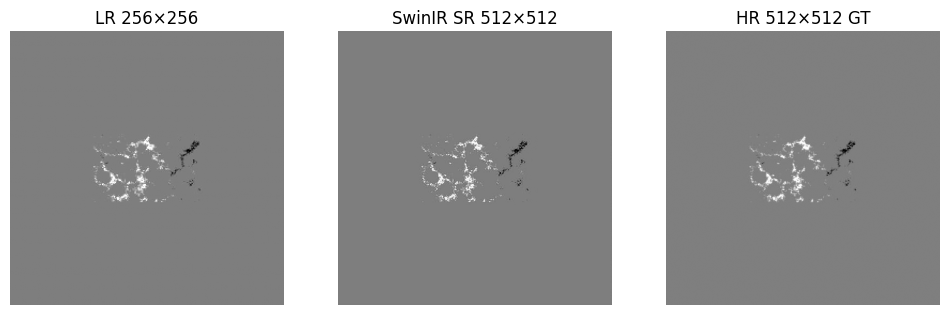

In [ ]:

import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

model.eval()

hr_path = random.choice(val_paths_hr)
print("Sample HR image:", hr_path)

img = Image.open(hr_path).convert("L")
hr_raw = np.array(img, dtype=np.uint8)
hr_norm = hr_raw.astype(np.float32) / 255.0

hr_tensor = torch.from_numpy(hr_norm).unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    lr_tensor = F.interpolate(
        hr_tensor, scale_factor=0.5, mode="bicubic", align_corners=False
    )

    sr_tensor = model(lr_tensor)

lr_img_norm = lr_tensor[0, 0].detach().cpu().numpy()
sr_img_norm = sr_tensor[0, 0].detach().cpu().numpy()

lr_img = np.clip(lr_img_norm * 255.0, 0, 255).astype(np.uint8)   # (256,256)
sr_img = np.clip(sr_img_norm * 255.0, 0, 255).astype(np.uint8)   # (512,512)
hr_img = hr_raw                                                   # (512,512)

print("LR shape:", lr_img.shape)
print("SR shape:", sr_img.shape)
print("HR shape:", hr_img.shape)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(lr_img, cmap="gray", vmin=0, vmax=255)
plt.title("LR 256×256")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(sr_img, cmap="gray", vmin=0, vmax=255)
plt.title("SwinIR SR 512×512")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(hr_img, cmap="gray", vmin=0, vmax=255)
plt.title("HR 512×512 GT")
plt.axis("off")

plt.show()
